In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d, RegularGridInterpolator
from scipy.ndimage import map_coordinates
import json
import pickle
import os

In [4]:
camCalibData = {}
for i in range(10):
    camCalibData[i] = json.load(open('kcalibration_171204_pose1.json'))['sensors'][i]

In [5]:
aligned = cv2.imread('segmentation.png')/255.
with open('dep.pickle', 'rb') as handle:
    dep = pickle.load(handle)
expected = cv2.imread('expected.png')/255.

In [6]:
cam_id1 = 0
cam_id2 = 5
FX_DEPTH = camCalibData[cam_id1]['K_depth'][0][0]
FY_DEPTH = camCalibData[cam_id1]['K_depth'][1][1]
CX_DEPTH = camCalibData[cam_id1]['K_depth'][0][2]
CY_DEPTH = camCalibData[cam_id1]['K_depth'][1][2]

# compute point cloud:
pcd = []
dict_pt2col = {}
height, width = dep.shape
cnt = 0
for i in range(height):
   for j in range(width):
       z = dep[i][j]
       x = (j - CX_DEPTH) * z / FX_DEPTH
       y = (i - CY_DEPTH) * z / FY_DEPTH
       pcd.append([x, y, z])
       dict_pt2col[cnt] = aligned[i][j]
       cnt += 1
       
rot = np.array(camCalibData[cam_id1]['M_depth'])[:3,:3]
trans = np.array(camCalibData[cam_id1]['M_depth'])[:3, 3]
pw = rot.T@(np.array(pcd).T - np.repeat(trans.reshape(-1,1), len(pcd), axis=1))

rot_ = np.array(camCalibData[cam_id2]['M_world2sensor'])[:3,:3]
trans_ = np.array(camCalibData[cam_id2]['M_world2sensor'])[:3, 3]
print("trans_: ", trans_)

# If I set trans_ to the below, it seems to work for this camera:
trans_ = np.array([1496,  -1050.01476608,  712.7038947189822])

points_in_new_sensor = rot_@ pw + np.repeat(trans_.reshape(-1,1), len(pcd), axis=1)
points_in_image_plane_new_sensor = (np.array(camCalibData[cam_id2]['K_depth'])@points_in_new_sensor).T

points_in_image_plane_new_sensor[:,0] = np.divide(points_in_image_plane_new_sensor[:,0], points_in_image_plane_new_sensor[:,2], out=np.zeros_like(points_in_image_plane_new_sensor[:,0]), where=points_in_image_plane_new_sensor[:,2]!=0)
points_in_image_plane_new_sensor[:,1] = np.divide(points_in_image_plane_new_sensor[:,1], points_in_image_plane_new_sensor[:,2], out=np.zeros_like(points_in_image_plane_new_sensor[:,1]), where=points_in_image_plane_new_sensor[:,2]!=0)

output_img = np.zeros_like(aligned)
cnt = 0
for i in range(points_in_image_plane_new_sensor.shape[0]):
   x = points_in_image_plane_new_sensor[i, 0]
   y = points_in_image_plane_new_sensor[i, 1]
   if x >= 0 and y >= 0 and y < 424 and x < 512:
      output_img[int(y)][int(x)] = dict_pt2col[i]

trans_:  [ 1.46152057 -1.19923317  0.97934372]


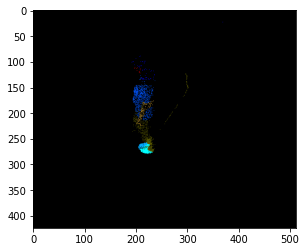

In [7]:
# Noisy projection of segmentation from one camera to another camera
plt.imshow(cv2.flip(cv2.flip(output_img, 1), 0))

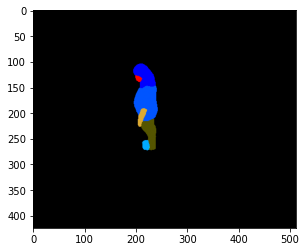

In [8]:
# This is based on actual segmentation from a different view image
plt.imshow(expected)